In [469]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("./utils")

import numpy as np
import pandas as pd
import joblib
import pickle
import seaborn as sns
import talib
from utils.get_targets import get_first_threshold_bump, get_close_price_target
from stockstats import StockDataFrame
from matplotlib import pyplot as plt
import optuna
import random

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error

from catboost import CatBoostClassifier, CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)
random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [536]:
DATA_PATH = "./data/prices/BTC_15minute_train.csv"
TEST_PATH = "./data/prices/BTC_15minute_test.csv"
MEAN_TARGET_ENCODING_PATH = ".strategies/bitcoin_lgb_mean_target_encoding/mean_target_encoding"
MODEL_PATH = "./bitcoin_trader.pickle"

TEST_RATIO = 0.2
TARGET_BOUNDARY = 1000
TIME_LAG = 2

In [537]:
def prepare_dataset(path: str) -> pd.DataFrame:
    data = pd.read_csv(DATA_PATH, index_col=0)
    data = data.join(pd.Series(get_close_price_target(data, TIME_LAG), name="target"))
    data.dropna(inplace=True)
    
    return data

In [538]:
data = prepare_dataset(DATA_PATH)
data

,volume,open,close,high,low,date,ticker,target
0,88.874451,7140.74,7145.34,7162.059278,7132.54,2020-04-19 08:58:00,X:BTCUSD,23.460000
1,364.228687,7145.34,7160.58,7162.700000,7133.37,2020-04-19 09:13:00,X:BTCUSD,21.440000
2,473.196157,7160.58,7168.80,7170.000000,7140.68,2020-04-19 09:28:00,X:BTCUSD,6.700000
3,321.947133,7164.59,7182.02,7205.000000,7144.21,2020-04-19 09:43:00,X:BTCUSD,-3.420000
4,305.291586,7181.91,7175.50,7196.100000,7161.62,2020-04-19 09:58:00,X:BTCUSD,-8.700000
...,...,...,...,...,...,...,...,...
54934,274.291167,60117.11,60115.51,60328.400000,60022.41,2021-11-17 17:30:00,X:BTCUSD,293.060000
54935,331.906320,60115.51,60248.52,60524.500000,60081.00,2021-11-17 17:45:00,X:BTCUSD,336.470000
54936,301.581101,60251.15,60408.57,60483.000000,60219.48,2021-11-17 18:00:00,X:BTCUSD,97.390000
54937,539.886899,60408.58,60584.99,60649.000000,60394.04,2021-11-17 18:15:00,X:BTCUSD,-89.170000


In [539]:
train_df, test_df = train_test_split(data, test_size=TEST_RATIO, shuffle=False)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
display(train_df)
display(test_df)

,volume,open,close,high,low,date,ticker,target
0,88.874451,7140.74,7145.34,7162.059278,7132.54,2020-04-19 08:58:00,X:BTCUSD,23.46
1,364.228687,7145.34,7160.58,7162.700000,7133.37,2020-04-19 09:13:00,X:BTCUSD,21.44
2,473.196157,7160.58,7168.80,7170.000000,7140.68,2020-04-19 09:28:00,X:BTCUSD,6.70
3,321.947133,7164.59,7182.02,7205.000000,7144.21,2020-04-19 09:43:00,X:BTCUSD,-3.42
4,305.291586,7181.91,7175.50,7196.100000,7161.62,2020-04-19 09:58:00,X:BTCUSD,-8.70
...,...,...,...,...,...,...,...,...
43946,66.420351,34605.18,34553.20,34616.820000,34532.40,2021-07-25 10:15:00,X:BTCUSD,-163.52
43947,49.323155,34560.90,34443.00,34567.990000,34429.53,2021-07-25 10:30:00,X:BTCUSD,45.44
43948,116.340815,34429.53,34389.68,34450.200000,34300.00,2021-07-25 10:45:00,X:BTCUSD,-60.10
43949,42.673843,34389.67,34488.44,34496.510000,34351.17,2021-07-25 11:00:00,X:BTCUSD,-75.60


,volume,open,close,high,low,date,ticker,target
0,71.416464,34329.54,34412.84,34421.00,34301.40,2021-07-25 11:30:00,X:BTCUSD,-78.280000
1,48.744982,34412.05,34420.68,34471.45,34368.50,2021-07-25 11:45:00,X:BTCUSD,-74.680000
2,131.570592,34420.67,34334.56,34420.67,34258.08,2021-07-25 12:00:00,X:BTCUSD,-56.560000
3,45.816039,34334.55,34346.00,34387.91,34313.58,2021-07-25 12:15:00,X:BTCUSD,-26.000000
4,91.927732,34343.14,34278.00,34445.59,34233.32,2021-07-25 12:30:00,X:BTCUSD,-19.070000
...,...,...,...,...,...,...,...,...
10983,274.291167,60117.11,60115.51,60328.40,60022.41,2021-11-17 17:30:00,X:BTCUSD,293.060000
10984,331.906320,60115.51,60248.52,60524.50,60081.00,2021-11-17 17:45:00,X:BTCUSD,336.470000
10985,301.581101,60251.15,60408.57,60483.00,60219.48,2021-11-17 18:00:00,X:BTCUSD,97.390000
10986,539.886899,60408.58,60584.99,60649.00,60394.04,2021-11-17 18:15:00,X:BTCUSD,-89.170000


In [540]:
def estimate_mean_target_regularization(category, global_mean: float, category_means: pd.Series,
                                        category_counts: pd.Series, alpha: float) -> float:
    try:
        return (category_counts[category] * category_means[category] + global_mean * alpha) / (category_counts[category] * alpha)
    except:
        return global_mean

In [541]:
def mean_target_regularization(dataset: pd.DataFrame, column: str, target_name: str, train: bool = True) -> pd.Series:
    encoding_file_path = MEAN_TARGET_ENCODING_PATH + "_" + column + ".pickle"
    if train:
        encoding = {
            "global_mean": dataset[target_name].mean(),
            "counts": dataset.groupby(dataset[column]).count()[target_name],
            "category_means": dataset.groupby(dataset[column]).mean()[target_name]
        }
        with open(encoding_file_path, "wb") as output_file:
            pickle.dump(encoding, output_file)
    else:
        with open(encoding_file_path, "rb") as input_file:
            encoding = pickle.load(input_file)
    
    global_mean = encoding["global_mean"]
    counts = encoding["counts"]
    category_means = encoding["category_means"]
    
    target_mean = dataset[column].apply(
        lambda category: estimate_mean_target_regularization(
            category,
            global_mean=global_mean,
            category_means=category_means,
            category_counts=counts,
            alpha=10
        )
    )
    
    return target_mean

In [542]:
def get_features(dataset: pd.DataFrame, train: bool = True) -> pd.DataFrame:
    indicators = [
        "macd", "macds", "macdh",
        "macd_5_ema", "macd_5_mstd", "macd_10_ema", "macd_10_mstd",
        "macds_5_ema", "macds_10_ema", "macds_20_ema", "macds_5_mstd",
        "rsi", "rsi_6",
        "volume_5_ema", "volume_10_ema", "volume_20_ema", "volume_10_mstd",
        "close_5_mstd", "close_15_mstd", "close_20_mstd", "close_30_mstd",
        "trix", "middle_10_trix",
        "wr", "wr_6",
        "atr", "atr_5",
        "dma",
        "ppo", "ppos",
        "volume", "close"
    ]
    
    result_dataset = StockDataFrame(dataset.copy())
    
    result_dataset["apo"] = talib.APO(result_dataset["close"])
    result_dataset["bop"] = talib.BOP(result_dataset["open"], result_dataset["high"], result_dataset["low"],
                                     result_dataset["close"])
    result_dataset["cmo"] = talib.CMO(result_dataset["close"])
    result_dataset["minus_dm"] = talib.MINUS_DM(result_dataset["high"], result_dataset["low"])
    result_dataset["mom"] = talib.MOM(result_dataset["close"])
    result_dataset["willr"] = talib.WILLR(result_dataset["high"], result_dataset["low"],
                                     result_dataset["close"])
    
    rsi_bins = [0, 20, 40, 60, 80, 100]
    rsi_labels = [0, 1, 2, 3, 4]
    wr_bins = [-100, -80, -60, -40, -20, 0]
    wr_labels = [0, 1, 2, 3, 4]
    macdh_bins = np.linspace(-1000, 1000, 6)
    macdh_labels = [0, 1, 2, 3, 4]
    
    result_dataset["rsi_bins"] = pd.cut(result_dataset["rsi"], rsi_bins, labels=rsi_labels).astype(float)
    result_dataset["rsi_6_bins"] = pd.cut(result_dataset["rsi_6"], rsi_bins, labels=rsi_labels).astype(float)
    result_dataset["wr_bins"] = pd.cut(result_dataset["wr"], wr_bins, labels=wr_labels).astype(float)
    result_dataset["wr_6_bins"] = pd.cut(result_dataset["wr_6"], wr_bins, labels=wr_labels).astype(float)
    result_dataset["macdh_bins"] = pd.cut(result_dataset["macdh"], macdh_bins, labels=macdh_labels).astype(float)
        
    result_dataset["rsi_mean_target"] = mean_target_regularization(result_dataset, "rsi_bins", "target", train)
    result_dataset["rsi_6_mean_target"] = mean_target_regularization(result_dataset, "rsi_6_bins", "target", train)
    result_dataset["wr_mean_target"] = mean_target_regularization(result_dataset, "wr_bins", "target", train)
    result_dataset["wr_6_mean_target"] = mean_target_regularization(result_dataset, "wr_6_bins", "target", train)
    result_dataset["macdh_mean_target"] = mean_target_regularization(result_dataset, "macdh_bins", "target", train)
    
    additional_columns = ["apo", "bop", "cmo", "minus_dm", "mom", "willr", "rsi_mean_target",
                          "rsi_6_mean_target", "wr_mean_target", "wr_6_mean_target", "macdh_mean_target"]
    
    if train:
        additional_columns += ["target"]
    
    return result_dataset[indicators + additional_columns]

In [535]:
train_preprocessed_df = get_features(train_df, train=True).reset_index(drop=True)
test_preprocessed_df = get_features(test_df, train=False).reset_index(drop=True)
test_preprocessed_df["target"] = test_df["target"]

display(train_preprocessed_df)
display(test_preprocessed_df)

,macd,macds,macdh,macd_5_ema,macd_5_mstd,macd_10_ema,macd_10_mstd,macds_5_ema,macds_10_ema,macds_20_ema,macds_5_mstd,rsi,rsi_6,volume_5_ema,volume_10_ema,volume_20_ema,volume_10_mstd,close_5_mstd,close_15_mstd,close_20_mstd,close_30_mstd,trix,middle_10_trix,wr,wr_6,atr,atr_5,dma,ppo,ppos,volume,close,apo,bop,cmo,minus_dm,mom,willr,rsi_mean_target,rsi_6_mean_target,wr_mean_target,wr_6_mean_target,macdh_mean_target,target
0,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,88.874451,88.874451,88.874451,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-56.638506,-56.638506,29.519278,29.519278,0.0000,0.000000,0.000000,88.874451,7145.34,NaN,0.155830,NaN,NaN,NaN,NaN,1.240645,1.240645,-0.473208,-0.324026,0.050116,23.46
1,0.341923,0.189957,0.151966,0.205154,0.241776,0.188058,0.241776,0.113974,0.104476,0.099728,0.134320,100.000000,100.000000,254.086993,240.319281,233.435425,194.704847,10.776307,10.776307,10.776307,10.776307,0.033897,0.012968,-7.029178,-7.029178,29.421134,29.414124,0.0000,0.004780,0.002656,364.228687,7160.58,NaN,0.519605,NaN,NaN,NaN,NaN,-2.743799,0.064791,-0.183748,-0.794505,0.050116,21.44
2,0.690580,0.395130,0.295449,0.435092,0.345295,0.390068,0.345295,0.247154,0.221317,0.208198,0.197614,100.000000,100.000000,357.875544,333.934238,321.474129,198.072814,11.903764,11.903764,11.903764,11.903764,0.031902,0.016576,-3.203417,-3.203417,29.384896,29.375548,0.0000,0.009647,0.005521,473.196157,7168.80,NaN,0.280355,NaN,NaN,NaN,NaN,-2.743799,0.064791,-0.183748,-0.794505,0.050116,6.70
3,1.309534,0.704888,0.604646,0.798322,0.558989,0.692991,0.558989,0.437289,0.380632,0.351584,0.301700,100.000000,100.000000,342.951435,329.985021,321.610678,161.859999,15.357034,15.357034,15.357034,15.357034,0.033877,0.024722,-31.714049,-31.714049,38.129250,40.017300,0.0000,0.018276,0.009842,321.947133,7182.02,NaN,0.286725,NaN,NaN,NaN,NaN,-2.743799,0.064791,0.254372,0.408932,0.050116,-3.42
4,1.358850,0.899427,0.459423,1.013501,0.594948,0.884141,0.594948,0.614697,0.529564,0.484103,0.367202,82.880563,79.665951,328.494337,322.896207,317.663228,140.207564,14.229713,14.229713,14.229713,14.229713,0.031634,0.028278,-40.712117,-40.712117,37.287427,38.370079,0.0000,0.018958,0.012554,305.291586,7175.50,NaN,-0.185905,NaN,NaN,NaN,NaN,-2.743799,-0.259662,-0.473208,-0.324026,0.050116,-8.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43946,60.844088,86.533824,-25.689736,75.094176,12.177277,88.106409,34.861334,97.973472,100.687086,91.432792,11.528893,53.533951,48.611595,80.438451,91.628480,105.550279,23.391180,65.861478,111.700633,132.240488,163.399018,0.033490,0.024436,-60.612393,-33.140070,143.753025,130.922611,256.2578,0.176363,0.251069,66.420351,34553.20,99.265833,-0.615731,7.067902,348.231913,-167.80,-60.612393,-0.037015,-0.102359,-0.197490,0.408932,0.050116,-163.52
43947,46.981578,78.623375,-31.641797,65.723310,10.405994,80.629167,35.454756,91.523439,96.675502,90.212848,11.193572,47.300555,35.607060,70.066686,83.936603,100.195315,26.153879,70.355014,116.088902,126.732923,161.522650,0.028364,0.018669,-82.753355,-68.995160,143.374952,132.430089,212.2138,0.136197,0.228095,49.323155,34443.00,62.448526,-0.851509,-5.398891,426.228205,-346.20,-82.753355,-0.037015,0.398402,2.243882,-0.122562,0.050116,45.44
43948,31.331787,69.165057,-37.833270,54.259469,15.489806,71.666007,34.734652,84.070645,91.673603,88.208296,11.928462,44.594891,30.819919,85.491396,89.828278,101.732981,25.290497,85.998185,129.104558,123.227461,160.711336,0.022413,0.011318,-83.837947,-73.151308,143.862455,135.984071,167.7764,0.090850,0.200646,116.340815,34389.68,31.162372,-0.265313,-10.810218,525.313333,-354.28,-83.837947,-0.037015,0.398402,2.243882,-0.122562,0.050116,-60.10
43949,26.591788,60.650403,-34.058615,45.036909,17.533351,63.470694,32.279538,76.263898,86.033021,85.583735,12.991451,50.269149,46.736280,71.218878,81.254744,96.108301

,macd,macds,macdh,macd_5_ema,macd_5_mstd,macd_10_ema,macd_10_mstd,macds_5_ema,macds_10_ema,macds_20_ema,macds_5_mstd,rsi,rsi_6,volume_5_ema,volume_10_ema,volume_20_ema,volume_10_mstd,close_5_mstd,close_15_mstd,close_20_mstd,close_30_mstd,trix,middle_10_trix,wr,wr_6,atr,atr_5,dma,ppo,ppos,volume,close,apo,bop,cmo,minus_dm,mom,willr,rsi_mean_target,rsi_6_mean_target,wr_mean_target,wr_6_mean_target,macdh_mean_target,target
0,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,71.416464,71.416464,71.416464,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-6.822742,-6.822742,119.600000,119.600000,0.000000,0.000000,0.000000,71.416464,34412.84,NaN,0.696488,NaN,NaN,NaN,NaN,1.240645,1.240645,-0.183748,-0.794505,0.050116,-78.280000
1,0.175897,0.097721,0.078177,0.105538,0.124378,0.096744,0.124378,0.058632,0.053746,0.051303,0.069099,100.000000,100.000000,57.813575,58.947149,59.513936,16.031158,5.543717,5.543717,5.543717,5.543717,0.003621,0.020228,-29.855925,-29.855925,110.966667,110.350000,0.000000,0.000511,0.000284,48.744982,34420.68,NaN,0.083827,NaN,NaN,NaN,NaN,-2.743799,0.064791,0.254372,0.408932,0.050116,-74.680000
2,-2.446448,-0.944971,-1.501477,-1.103297,1.465875,-0.925602,1.465875,-0.416759,-0.347731,-0.314523,0.575866,7.794433,7.051374,92.751109,88.141291,85.972708,42.803031,47.619811,47.619811,47.619811,47.619811,-0.012201,-0.000508,-64.156161,-64.156161,129.467824,131.763934,0.000000,-0.007114,-0.002748,131.570592,34334.56,NaN,-0.529614,NaN,NaN,NaN,NaN,18.753585,5.151107,-0.197490,-0.122562,0.050116,-56.560000
3,-3.166149,-1.697403,-1.468746,-1.960174,1.698148,-1.663763,1.698148,-0.948719,-0.792388,-0.713739,0.849486,18.539538,19.045948,73.255003,74.197006,74.380099,39.802011,44.517263,44.517263,44.517263,44.517263,-0.014914,-0.005897,-58.794582,-58.794582,114.115395,112.307995,0.000000,-0.009210,-0.004937,45.816039,34346.00,NaN,0.154043,NaN,NaN,NaN,NaN,18.753585,5.151107,-0.473208,-0.324026,0.050116,-26.000000
4,-6.196445,-3.035766,-3.160679,-3.586420,2.615839,-2.964972,2.615839,-1.749907,-1.436401,-1.275417,1.301091,10.618477,9.917377,80.423207,79.287015,78.624722,35.350889,59.221568,59.221568,59.221568,59.221568,-0.018812,-0.009629,-81.237139,-81.237139,136.758070,142.044431,0.000000,-0.018038,-0.008834,91.927732,34278.00,NaN,-0.306873,NaN,NaN,NaN,NaN,18.753585,5.151107,2.243882,2.110248,0.050116,-19.070000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10983,38.066402,21.635952,16.430450,22.624538,20.815023,23.789060,43.932133,20.647366,41.013919,60.591725,7.092248,52.386976,53.837436,351.087158,382.999638,396.806509,126.876112,136.844754,303.788524,318.409830,410.138927,-0.001938,-0.005062,-32.841889,-40.400575,371.386376,347.752909,76.308881,0.063419,0.036008,274.291167,60115.51,-268.223782,-0.005229,4.773953,887.558184,546.470000,-32.841889,-0.037015,-0.102359,0.254372,-0.324026,0.050116,293.060000
10984,50.139613,27.336684,22.802928,31.796230,8.955736,28.580069,47.973340,22.877139,38.527149,57.424579,7.404347,55.376317,61.703168,344.693545,373.709944,390.625538,116.743169,134.260098,306.196826,305.424234,359.254901,0.001032,0.001074,-23.882379,-47.085921,376.537349,366.902327,137.567881,0.083510,0.045508,331.906320,60248.52,-205.529231,0.299910,10.752634,824.161171,777.010000,-23.882379,-0.037015,-0.259662,0.254372,-0.324026,0.050116,336.470000
10985,71.794811,36.228310,35.566501,45.129090,16.201105,36.437295,49.970197,27.327529,38.109178,55.405886,9.020932,58.733703,69.265112,330.322730,360.595609,382.145116,115.641309,128.181644,316.222190,302.580583,354.238202,0.005064,0.007700,-10.032192,-23.089486,368.464681,346.225862,207.029481,0.119523,0.060311,301.581101,60408.57,-135.324551,0.597374,17.467405,765.292516,846.730000,-10.032192,-0.037015,-0.259662,-0.183748,0.408932,0.050116,97.390000
10986,102.016350,49.385918,52.630432,64.091510,27.725614,48.360759,50.5

In [507]:
print(f"Всего {(train_preprocessed_data['target'] >= TARGET_BOUNDARY).sum()} выбросов")

Всего 173 выбросов


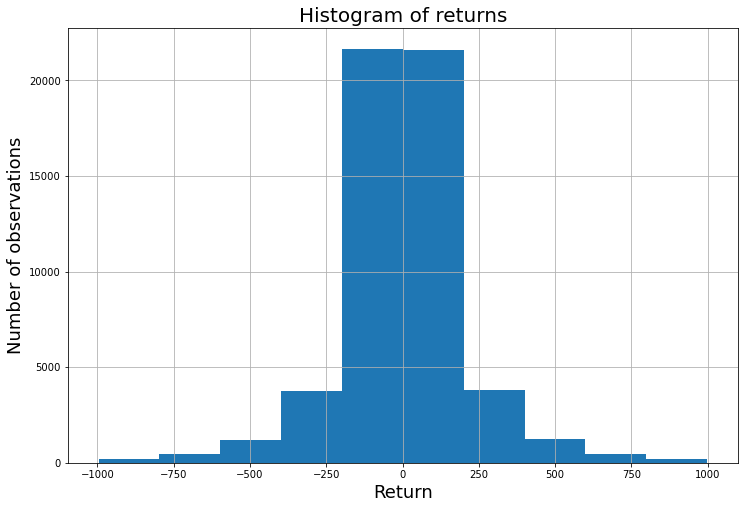

In [508]:
plt.figure(figsize=(12, 8))
target_bounded = train_preprocessed_data.loc[np.abs(train_preprocessed_data["target"]) < TARGET_BOUNDARY, "target"]
plt.hist(target_bounded)
plt.grid()

plt.title("Histogram of returns", fontsize=20)
plt.xlabel("Return", fontsize=18)
plt.ylabel("Number of observations", fontsize=18)
plt.show()

In [509]:
target_corr = train_preprocessed_data.corr()["target"]
print("Слабо коррелированные признаки:", target_corr[np.abs(target_corr) < 0.025].index)
data_preprocessed.corr()

Слабо коррелированные признаки: Index(['macd', 'macds', 'macd_5_ema', 'macd_10_ema', 'macd_10_mstd',
       'macds_5_ema', 'macds_10_ema', 'macds_20_ema', 'macds_5_mstd', 'rsi',
       'rsi_6', 'volume_20_ema', 'volume_10_mstd', 'close_15_mstd',
       'close_20_mstd', 'close_30_mstd', 'trix', 'middle_10_trix', 'wr', 'atr',
       'atr_5', 'dma', 'ppo', 'ppos', 'close', 'apo', 'cmo', 'minus_dm',
       'willr'],
      dtype='object')


,macd,macds,macdh,macd_5_ema,macd_5_mstd,macd_10_ema,macd_10_mstd,macds_5_ema,macds_10_ema,macds_20_ema,macds_5_mstd,rsi,rsi_6,volume_5_ema,volume_10_ema,volume_20_ema,volume_10_mstd,close_5_mstd,close_15_mstd,close_20_mstd,close_30_mstd,trix,middle_10_trix,wr,wr_6,atr,atr_5,dma,ppo,ppos,volume,close,target,apo,bop,cmo,minus_dm,mom,willr,rsi_mean_target,rsi_6_mean_target,wr_mean_target,wr_6_mean_target,macdh_mean_target
macd,1.000000,0.951833,0.345291,0.983050,-0.084219,0.943442,-0.055303,0.898655,0.837633,0.744664,-0.032275,0.672122,0.431903,-0.100404,-0.099589,-0.085515,-0.113549,-0.152105,-0.088128,-0.062533,-0.034000,0.901987,0.897870,0.346717,0.115663,-0.142224,-0.182189,0.957182,0.921939,0.877050,-0.079674,0.029386,-0.023134,0.905458,0.031299,0.672129,-0.479530,0.612315,0.346717,-0.167060,-0.268466,-0.146908,-0.088680,-0.092308
macds,0.951833,1.000000,0.040900,0.990186,-0.103115,0.999539,-0.081726,0.989076,0.958493,0.888135,-0.054608,0.550714,0.266728,-0.090336,-0.097811,-0.092394,-0.107094,-0.153787,-0.113423,-0.086460,-0.049516,0.896678,0.844860,0.176577,-0.001006,-0.157024,-0.181176,0.993577,0.876641,0.921442,-0.065409,0.030724,-0.014730,0.854790,0.002985,0.550719,-0.436713,0.373454,0.176577,-0.119164,-0.162203,-0.064499,-0.010257,-0.049031
macdh,0.345291,0.040900,1.000000,0.172664,0.041175,0.014969,0.069935,-0.098950,-0.204195,-0.291794,0.061972,0.504594,0.591026,-0.050681,-0.025148,0.004136,-0.042225,-0.024947,0.059985,0.060863,0.040766,0.194715,0.339904,0.589365,0.379985,0.017160,-0.039149,0.077991,0.321062,0.037658,-0.059426,0.001719,-0.030298,0.334240,0.092858,0.504602,-0.225934,0.852259,0.589365,-0.179654,-0.378370,-0.281304,-0.257582,-0.150724
macd_5_ema,0.983050,0.990186,0.172664,1.000000,-0.095031,0.985624,-0.069749,0.958769,0.910515,0.824124,-0.043555,0.599280,0.326679,-0.094616,-0.099220,-0.089865,-0.111675,-0.153687,-0.101967,-0.074447,-0.041078,0.914537,0.886134,0.241975,0.029163,-0.150509,-0.182262,0.989298,0.905938,0.912578,-0.069732,0.029813,-0.017426,0.901175,0.005156,0.599286,-0.454226,0.471897,0.241975,-0.135805,-0.199219,-0.092800,-0.029067,-0.064644
macd_5_mstd,-0.084219,-0.103115,0.041175,-0.095031,1.000000,-0.104691,0.820683,-0.109448,-0.114085,-0.119087,0.792332,-0.041152,-0.018409,0.347026,0.328260,0.293054,0.224642,0.805049,0.778577,0.711696,0.662704,-0.088981,-0.076610,0.006795,0.030665,0.716528,0.759595,-0.095855,-0.089770,-0.108047,0.276602,0.483889,0.035053,-0.068235,0.006516,-0.041185,0.656756,-0.001859,0.006795,0.155825,0.224885,0.134484,0.024253,0.170477
macd_10_ema,0.943442,0.999539,0.014969,0.985624,-0.104691,1.000000,-0.084179,0.992951,0.966706,0.901040,-0.056994,0.540723,0.255567,-0.089523,-0.097478,-0.092886,-0.105925,-0.153847,-0.115789,-0.089198,-0.051718,0.889904,0.833235,0.164359,-0.005221,-0.158482,-0.180993,0.991966,0.868792,0.920955,-0.064693,0.030984,-0.014092,0.840637,0.002907,0.540728,-0.433194,0.354950,0.164359,-0.116022,-0.155434,-0.059457,-0.007759,-0.046259
macd_10_mstd,-0.055303,-0.081726,0.069935,-0.069749,0.820683,-0.084179,1.000000,-0.092620,-0.101725,-0.111531,0.967689,-0.022177,0.001726,0.291239,0.314912,0.306132,0.228106,0.633606,0.894450,0.827659,0.748384,-0.064722,-0.048163,0.028226,0.043768,0.761995,0.772903,-0.072258,-0.065234,-0.090017,0.190776,0.515975,0.017886,-0.036120,0.004796,-0.022211,0.669528,0.027805,0.028226,0.111902,0.128418,0.081771,-0.008579,0.124175
macds_5_ema,0.898655,0.989076,-0.098950,0.958769,-0.109448,0.992951,-0.092620,1.000000,0.988707,0.936756,-0.065105,0.487770,0.197818,-0.083900,-0.094243,-0.093097,-0.099985,-0.150620,-0.123093,-0.097291,-0.057363,0.858764,0.783351,0.103841,-0.032806,-0.160556,-0.176176,0.976951,0.827089,0.911188,-0.059458,0.031030,-0.011574,0.787679,0.000630,0.487774,-0.408949,0.261674,0.103841,-0.099076,-0.119709,-0.033275,0.009801,-0.031521
macds_10_ema,0.837633,0.958493,-0.204195,0.910515,-0.114085,0.966706,-0.101725,0.988707,1.000000,0.976338,-0.074990,0.436396,0.151977,-0.079337,-0.091054,-0.093573,-0.092133,

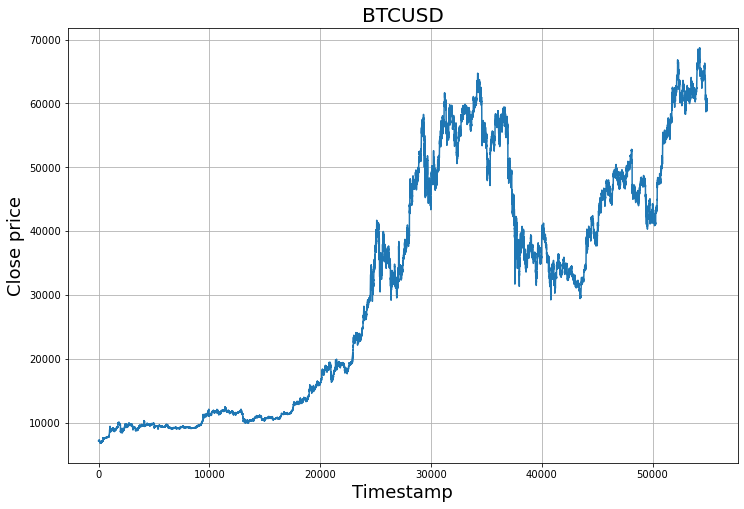

In [510]:
plt.figure(figsize=(12, 8))

plt.plot(range(train_data.shape[0]), train_data["close"])

plt.title("BTCUSD", fontsize=20)
plt.xlabel("Timestamp", fontsize=18)
plt.ylabel("Close price", fontsize=18)
plt.grid()
plt.show()

In [511]:
X_train = train_preprocessed_df.drop(["target"], axis=1).to_numpy()
y_train = train_preprocessed_df["target"].to_numpy()

X_test = test_preprocessed_df.drop(["target"], axis=1).to_numpy()
y_test = test_preprocessed_df["target"].to_numpy()

X_train.shape, X_test.shape

((43951, 43), (10988, 43))

In [512]:
X_train_bounded = X_train[np.abs(y_train) <= TARGET_BOUNDARY]
y_train_bounded = y_train[np.abs(y_train) <= TARGET_BOUNDARY]

In [513]:
cb_regressor = CatBoostRegressor(verbose=False)
cb_regressor.fit(X_train_bounded, y_train_bounded)

cb_predictions = cb_regressor.predict(X_test)
mean_squared_error(y_test, cb_predictions)

70996.77010888589

In [514]:
lgbm_regressor = LGBMRegressor()
lgbm_regressor.fit(X_train_bounded, y_train_bounded)

lgbm_predictions = lgbm_regressor.predict(X_test)
mean_squared_error(y_test, lgbm_predictions)

67602.01646792406

In [515]:
y_test

array([-78.28      , -74.68      , -56.56      , ...,  97.39      ,
       -89.17      , -79.30304541])

In [516]:
lgbm_predictions

array([ -2.4835998 ,  -5.11885334,  10.2386207 , ..., -64.88893519,
       -32.91869735, -15.9027397 ])

In [517]:
DECISION_BOUNDARY = 50

class_predictions = np.zeros(len(y_test))
class_predictions[lgbm_predictions > DECISION_BOUNDARY] = 1
class_predictions[lgbm_predictions < DECISION_BOUNDARY] = 2

true_classes = np.zeros(len(y_test))
true_classes[y_test > DECISION_BOUNDARY] = 1
true_classes[y_test < DECISION_BOUNDARY] = 2

confusion_matrix(true_classes, class_predictions)

array([[ 314, 4063],
       [ 323, 6288]], dtype=int64)

# Full dataset train

In [520]:
data = prepare_dataset(DATA_PATH)
data_preprocessed = get_features(data)
data_preprocessed

,macd,macds,macdh,macd_5_ema,macd_5_mstd,macd_10_ema,macd_10_mstd,macds_5_ema,macds_10_ema,macds_20_ema,macds_5_mstd,rsi,rsi_6,volume_5_ema,volume_10_ema,volume_20_ema,volume_10_mstd,close_5_mstd,close_15_mstd,close_20_mstd,close_30_mstd,trix,middle_10_trix,wr,wr_6,atr,atr_5,dma,ppo,ppos,volume,close,apo,bop,cmo,minus_dm,mom,willr,rsi_mean_target,rsi_6_mean_target,wr_mean_target,wr_6_mean_target,macdh_mean_target,target
0,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,0.000000,0.000000,0.000000,NaN,NaN,NaN,88.874451,88.874451,88.874451,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,-56.638506,-56.638506,29.519278,29.519278,0.000000,0.000000,0.000000,88.874451,7145.34,NaN,0.155830,NaN,NaN,NaN,NaN,1.940635,1.940635,-0.434660,-0.157314,0.136614,23.460000
1,0.341923,0.189957,0.151966,0.205154,0.241776,0.188058,0.241776,0.113974,0.104476,0.099728,0.134320,100.000000,100.000000,254.086993,240.319281,233.435425,194.704847,10.776307,10.776307,10.776307,10.776307,0.033897,0.012968,-7.029178,-7.029178,29.421134,29.414124,0.000000,0.004780,0.002656,364.228687,7160.58,NaN,0.519605,NaN,NaN,NaN,NaN,-0.128649,0.552815,-0.139624,-0.615724,0.136614,21.440000
2,0.690580,0.395130,0.295449,0.435092,0.345295,0.390068,0.345295,0.247154,0.221317,0.208198,0.197614,100.000000,100.000000,357.875544,333.934238,321.474129,198.072814,11.903764,11.903764,11.903764,11.903764,0.031902,0.016576,-3.203417,-3.203417,29.384896,29.375548,0.000000,0.009647,0.005521,473.196157,7168.80,NaN,0.280355,NaN,NaN,NaN,NaN,-0.128649,0.552815,-0.139624,-0.615724,0.136614,6.700000
3,1.309534,0.704888,0.604646,0.798322,0.558989,0.692991,0.558989,0.437289,0.380632,0.351584,0.301700,100.000000,100.000000,342.951435,329.985021,321.610678,161.859999,15.357034,15.357034,15.357034,15.357034,0.033877,0.024722,-31.714049,-31.714049,38.129250,40.017300,0.000000,0.018276,0.009842,321.947133,7182.02,NaN,0.286725,NaN,NaN,NaN,NaN,-0.128649,0.552815,0.243399,0.211518,0.136614,-3.420000
4,1.358850,0.899427,0.459423,1.013501,0.594948,0.884141,0.594948,0.614697,0.529564,0.484103,0.367202,82.880563,79.665951,328.494337,322.896207,317.663228,140.207564,14.229713,14.229713,14.229713,14.229713,0.031634,0.028278,-40.712117,-40.712117,37.287427,38.370079,0.000000,0.018958,0.012554,305.291586,7175.50,NaN,-0.185905,NaN,NaN,NaN,NaN,-0.128649,-0.279725,-0.434660,-0.157314,0.136614,-8.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54934,38.066402,21.635952,16.430450,22.624538,20.815023,23.789060,43.932133,20.647366,41.013919,60.591725,7.092248,52.386976,53.837436,351.087158,382.999638,396.806509,126.876112,136.844754,303.788524,318.409830,410.138927,-0.001938,-0.005062,-32.841889,-40.400575,371.386376,347.752909,76.308881,0.063419,0.036008,274.291167,60115.51,-268.223782,-0.005229,4.773953,887.558184,546.470000,-32.841889,-0.028277,-0.075004,0.243399,-0.157314,0.136614,293.060000
54935,50.139613,27.336684,22.802928,31.796230,8.955736,28.580069,47.973340,22.877139,38.527149,57.424579,7.404347,55.376317,61.703168,344.693545,373.709944,390.625538,116.743169,134.260098,306.196826,305.424234,359.254901,0.001032,0.001074,-23.882379,-47.085921,376.537349,366.902327,137.567881,0.083510,0.045508,331.906320,60248.52,-205.529231,0.299910,10.752634,824.161171,777.010000,-23.882379,-0.028277,-0.279725,0.243399,-0.157314,0.136614,336.470000
54936,71.794811,36.228310,35.566501,45.129090,16.201105,36.437295,49.970197,27.327529,38.109178,55.405886,9.020932,58.733703,69.265112,330.322730,360.595609,382.145116,115.641309,128.181645,316.222190,302.580583,354.238202,0.005064,0.007700,-10.032192,-23.089486,368.464681,346.225862,207.029481,0.119523,0.060311,301.581101,60408.57,-135.324551,0.597374,17.467405,765.292516,846.730000,-10.032192,-0.028277,-0.279725,-0.139624,0.211518,0.136614,97.390000
54937,102.016350,49.385918,52.630432,64.091510,27.725614,48.360759,50.508394,34.680325,40.159494,5

In [521]:
X = train_preprocessed_data.drop(["target"], axis=1).to_numpy()
y = train_preprocessed_data["target"].to_numpy()

In [522]:
lgbm_regressor = LGBMRegressor()
lgbm_regressor.fit(X, y)

LGBMRegressor()

In [523]:
with open(MODEL_PATH, "wb") as output_file:
    pickle.dump(lgbm_regressor, output_file)